In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision.models import vgg16
from HSI_class import HSI
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import zeroPadding
from datetime import datetime
import torch.nn.functional as F
import time
start_time = time.time()


# Check if GPU is available
print("GPU Available:", torch.cuda.is_available())

# If available, print the GPU name
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

seeded_run = True

sample_per_class = 5
num_per_category_augment_1 = 10
num_per_category_augment_2 = 10
epochs = 200

batch_size = 20
test_size = 0.5

random_indices = 0

GPU Available: False


/home/wijayanti/anaconda3/envs/TAFathan/lib/python3.13/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
import torch
import numpy as np
import random
import os

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # PyTorch determinism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)

if seeded_run:
    set_seed(42)
    print("seed has been set")


seed has been set


In [6]:
datasets_path = r"/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets"

datasets = []
dataset_path = []

i = 0
for filename in os.listdir(datasets_path):
    if i>2:
        break
    file_path = os.path.join(datasets_path, filename)
    dataset_path.append(file_path)

dataset_path = sorted(dataset_path)

for path in dataset_path:
    print(path)

for file in dataset_path:
    if i>10:
        break
    if os.path.isfile(file):  # Check if it's a file
        print(f"Processing file: {file}")
        hsi = HSI(file)
        datasets.append(hsi)
    i += 1

/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets/.ipynb_checkpoints
/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets/GM01.mat
/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets/GM02.mat
/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets/GM03.mat
/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets/GM04.mat
/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets/GM05.mat
/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets/GM06.mat
/home/wija

In [7]:
def testWithDataset(n): 
    hsi_test = datasets[n]

    test_img = hsi_test.img
    test_gt = hsi_test.gt

    patch_size = 9
    half_patch = patch_size // 2

    height = test_img.shape[0]
    width = test_img.shape[1]

    matrix=zeroPadding.zeroPadding_3D(test_img,half_patch) #add 0 in every side of the data
    print(f"img shape: {test_img.shape}")
    print(f"img shape after padding {matrix.shape}")
    print(f"number of pixel {width * height}")

    print(f"ground truth shape: {test_gt.shape}")

    indices0 = np.argwhere(test_gt == 0)
    indices1 = np.argwhere(test_gt == 1)

    print(f"indices = 0 shape: {indices0.shape}")
    print(f"indices = 1 shape: {indices1.shape}")

    num_samples = 50

    random_indices0 = indices0[np.random.choice(len(indices0), num_samples, replace=False)]
    random_indices1 = indices1[np.random.choice(len(indices1), num_samples, replace=False)]

    test_indices = np.vstack((random_indices0, random_indices1))

    print(test_indices.shape)

    return test_indices, test_gt, matrix

In [8]:
def predict_batch(model, feature_extractor, batch_input, device):
    with torch.no_grad():  # Disable gradient computation
        test_features = feature_extractor(batch_input)  # shape: (10, 128)
        test_features_np = test_features.numpy()     # convert to NumPy

    # --- Predict continuous values ---
    predicted_values = model.predict(test_features_np)

    # --- Convert to class labels using threshold ---
    predicted_classes = (predicted_values >= 0.5).astype(int)

    # --- Clip predicted values to [0, 1] as pseudo-probabilities ---
    positive_probs = np.clip(predicted_values, 0, 1)


    return predicted_classes, positive_probs


In [9]:
import createSample as CS

hsi_ = datasets[0]
patch_size = 9


indices_0 = []
indices_1 = []

print(f"random: {random_indices}")

if random_indices:
    print("generating random sample")
    selected_patch_0, selected_patch_1, indices_0, indices_1 = CS.createSample(hsi_, patch_size, sample_per_class)
else:
    print("using generated indices")
    indices_0 = [(np.int64(188), np.int64(124)), (np.int64(523), np.int64(150)), (np.int64(1003), np.int64(474)), (np.int64(616), np.int64(508)), (np.int64(905), np.int64(552))]
    indices_1 = [(np.int64(106), np.int64(606)), (np.int64(297), np.int64(468)), (np.int64(926), np.int64(35)), (np.int64(536), np.int64(519)), (np.int64(508), np.int64(442))]

    selected_patch_0, selected_patch_1 = CS.getSample(hsi_, patch_size, sample_per_class, indices_0, indices_1)


i =0
half_patch = patch_size // 2


indices = indices_0 +  indices_1

# Concatenating along axis 0
x_train = np.concatenate((selected_patch_0, selected_patch_1), )

y_train = np.array([])

gt = hsi_.gt
for indice in indices:
    # print(gt[indice[0]][indice[1]])
    y_train = np.append(y_train, gt[indice[0]][indice[1]])

count = np.count_nonzero(y_train == 0)  # Count elements equal to 0
print(f'number of element equal 0 {count}')

count = np.count_nonzero(y_train == 1)  # Count elements equal to 1
print(f'number of element equal 1 {count}')



# Print shape to verify
print(f"x_train shape: {x_train.shape}")  # Expected output: (10, 9, 9, 224)
print(f"y_train shape: {y_train.shape}") 


random: 0
using generated indices
hsi shape
(1243, 684, 224)
indices 0 used: [(np.int64(188), np.int64(124)), (np.int64(523), np.int64(150)), (np.int64(1003), np.int64(474)), (np.int64(616), np.int64(508)), (np.int64(905), np.int64(552))]
indices 1 used: [(np.int64(106), np.int64(606)), (np.int64(297), np.int64(468)), (np.int64(926), np.int64(35)), (np.int64(536), np.int64(519)), (np.int64(508), np.int64(442))]
number of element equal 0 5
number of element equal 1 5
x_train shape: (10, 9, 9, 224)
y_train shape: (10,)


In [10]:
i =1
half_patch = patch_size // 2
print(hsi_.img[indices_0[i][0]][indices_0[i][1]])
print(selected_patch_0[i][half_patch][half_patch])

print(hsi_.img[indices_1[i][0]][indices_1[i][1]])
print(selected_patch_1[i][half_patch][half_patch])
i =4
half_patch = patch_size // 2
print(hsi_.img[indices_0[i][0]][indices_0[i][1]])
print(selected_patch_0[i][half_patch][half_patch])

print(hsi_.img[indices_1[i][0]][indices_1[i][1]])
print(selected_patch_1[i][half_patch][half_patch])

[-207 -419  261  355  412  560  640  650  640  607  572  534  499  473
  439  410  385  367  348  320  295  273  255  230  209  195  185  173
  169  159  157  150  140  139  133  121  112  102  101   74   91   97
   95   80   94   94   86   81   85   74   79   82   89   85   86   80
   76   53   37   23   18  -64  -92  -57   29   40   53   69   77   83
   90   84   84   84   79   69   56   43   24  -14  -98 -107  -96 -115
  -21   11   23   29   39   40   50   62   66   64   68   70   71   72
   75   63   56   38   39   52    0  -36  -85    0    0    0    0    0
    0  -56  -47  -48  -86  -44  -62  -41    7   20   34   47   60   82
   70   74   67   72   72   77   70   75   75   79   74   69   70   74
   69   70   59   66   55   43   39   33   24   16    4  -20  -32    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   -9  -21   -3    0    7    3  -20    8   26   32   40   40   42   50
   53   55   51   58   55   50   55   57   54   54   50   52   53   55
   44 

In [11]:
import augmentation as aug
n_category = 2
band_size = 224


data_augment1, label_augment1 = aug.Augment_data(x_train, y_train, n_category, patch_size, band_size, num_per_category_augment_1)

data_augment2, label_augment2 = aug.Augment_data2(x_train, y_train, n_category, patch_size, band_size, num_per_category_augment_2)

print(f"hasil augmentasi 1 shape: {data_augment1.shape}")
print(f"label augmentai 1 shape: {label_augment1.shape}")

print(f"hasil augmentasi 2 shape: {data_augment2.shape}")
print(f"label augmentasi 2 shape: {label_augment2.shape}")

print(label_augment1)
print(label_augment2)



data_augment = np.concatenate((data_augment1, data_augment2))
label_augment = np.concatenate((label_augment1, label_augment2))

print(f"hasil augmentasi gabungan untuk training: {data_augment.shape}")
print(f"label augmentasi gabungan: {label_augment.shape}")

# print(label_augment)

# Count occurrences of each unique element
counts = np.bincount(label_augment)

# Print results
for i, count in enumerate(counts):
    print(f"Element {i} occurs {count} times.")

hasil augmentasi 1 shape: (20, 9, 9, 224)
label augmentai 1 shape: (20,)
hasil augmentasi 2 shape: (20, 9, 9, 224)
label augmentasi 2 shape: (20,)
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
hasil augmentasi gabungan untuk training: (40, 9, 9, 224)
label augmentasi gabungan: (40,)
Element 0 occurs 20 times.
Element 1 occurs 20 times.


In [12]:
class ConvTo1D(nn.Module):
    def __init__(self):
        super(ConvTo1D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=224, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # (batch_size, 128, 1, 1)
        self.flatten = nn.Flatten()               # (batch_size, 128)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        return x

feature_extractor = ConvTo1D()

In [13]:
print(data_augment.shape)
print(label_augment.shape)

x_data = data_augment 
y_labels = label_augment

x_data = torch.tensor(x_data)
x_data = x_data.to(torch.float32)
x_data = x_data.permute(0, 3, 1, 2)
print(f"X_train shape: {x_data.shape}")

feature_extractor = ConvTo1D()
feature_extractor.eval()
with torch.no_grad():  # No gradient needed for feature extraction
    features = feature_extractor(x_data)  # (100, 128)
    features_np = features.numpy() 

    

print(features_np.shape)

(40, 9, 9, 224)
(40,)
X_train shape: torch.Size([40, 224, 9, 9])
(40, 128)


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X = features_np
y = y_labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)


print(y_train)
print(y_val)

[0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 1 0 1]
[1 1 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1]


In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np



pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=42, max_iter=1000)  # Set random_state
)
pipeline.fit(X_train, y_train)

# --- Predict probabilities for class 1 ---
positive_probs = pipeline.predict_proba(X_val)[:, 1]

# --- Convert probabilities to class labels using 0.5 threshold ---
predicted_classes = (positive_probs >= 0.5).astype(int)

# --- Display predictions with probabilities ---
for i, (pred, prob) in enumerate(zip(predicted_classes, positive_probs)):
    print(f"Sample {i}: Predicted = {pred}, Prob(class 1) = {prob:.4f}")

# --- Accuracy ---
acc = accuracy_score(y_val, predicted_classes)
print(f"Validation Accuracy: {acc:.4f}")


Sample 0: Predicted = 1, Prob(class 1) = 0.9999
Sample 1: Predicted = 1, Prob(class 1) = 0.9999
Sample 2: Predicted = 1, Prob(class 1) = 0.9850
Sample 3: Predicted = 0, Prob(class 1) = 0.0041
Sample 4: Predicted = 0, Prob(class 1) = 0.0052
Sample 5: Predicted = 1, Prob(class 1) = 0.9847
Sample 6: Predicted = 1, Prob(class 1) = 0.9998
Sample 7: Predicted = 0, Prob(class 1) = 0.0041
Sample 8: Predicted = 1, Prob(class 1) = 0.9999
Sample 9: Predicted = 0, Prob(class 1) = 0.0041
Sample 10: Predicted = 0, Prob(class 1) = 0.0052
Sample 11: Predicted = 0, Prob(class 1) = 0.0029
Sample 12: Predicted = 1, Prob(class 1) = 0.9795
Sample 13: Predicted = 1, Prob(class 1) = 0.9980
Sample 14: Predicted = 1, Prob(class 1) = 0.9617
Sample 15: Predicted = 0, Prob(class 1) = 0.0025
Sample 16: Predicted = 1, Prob(class 1) = 0.9999
Sample 17: Predicted = 0, Prob(class 1) = 0.0052
Sample 18: Predicted = 0, Prob(class 1) = 0.0086
Sample 19: Predicted = 1, Prob(class 1) = 0.9914
Validation Accuracy: 1.0000


In [16]:
def testWithWholeDataset(n): 
    hsi_test = datasets[n]

    test_img = hsi_test.img
    gt= hsi_test.gt

    patch_size = 9
    half_patch = patch_size // 2

    height = test_img.shape[0]
    width = test_img.shape[1]

    matrix=zeroPadding.zeroPadding_3D(test_img,half_patch) #add 0 in every side of the data
    print(f"img shape: {test_img.shape}")
    print(f"img shape after padding {matrix.shape}")
    print(f"number of pixel {width * height}")

    print(f"ground truth shape: {gt.shape}")

    indices0 = np.argwhere(gt == 0)
    indices1 = np.argwhere(gt == 1)

    print(f"indices = 0 shape: {indices0.shape}")
    print(f"indices = 1 shape: {indices1.shape}")

    return matrix, gt, indices0.shape, indices1.shape

In [17]:
def predict_batch_whole(model, feature_extractor, batch_input, device):
    with torch.no_grad():  # Disable gradient computation
        test_features = feature_extractor(batch_input)  # shape: (10, 128)
        test_features_np = test_features.numpy()     # convert to NumPy

    # --- Predict continuous values ---
    predicted_values = model.predict(test_features_np)

    # --- Convert to class labels using threshold ---
    predicted_classes = (predicted_values >= 0.5).astype(int)

    # --- Clip predicted values to [0, 1] as pseudo-probabilities ---
    positive_probs = np.clip(predicted_values, 0, 1)


    return predicted_classes, positive_probs
   

In [18]:
from torch.utils.data import Dataset, DataLoader


class PatchDataset(Dataset):
    def __init__(self, matrix, gt, half_patch, expected_shape):
        self.matrix = matrix
        self.gt = gt
        self.half_patch = half_patch
        self.expected_shape = expected_shape
        self.size_x, self.size_y = matrix.shape[0], matrix.shape[1]
        self.valid_coords = [
            (x, y)
            for x in range(half_patch, self.size_x - half_patch)
            for y in range(half_patch, self.size_y - half_patch)
        ]

    def __len__(self):
        return len(self.valid_coords)

    def __getitem__(self, idx):
        x, y = self.valid_coords[idx]
        true_label = self.gt[x - self.half_patch, y - self.half_patch]

        selected_rows = self.matrix[x- self.half_patch:x + 2 * self.half_patch + 1 - self.half_patch, :]
        testing_patch = selected_rows[:, y - self.half_patch:y + 2 * self.half_patch + 1 - self.half_patch]

        # Verify patch size
        if testing_patch.shape != self.expected_shape:
            raise ValueError(f"Patch at ({x},{y}) has wrong shape {testing_patch.shape}")

        patch_tensor = torch.tensor(testing_patch, dtype=torch.float32)
        patch_tensor = patch_tensor.permute(2, 0, 1)  # (C, H, W)

        return patch_tensor, true_label, x, y  # Also return (x, y) for positioning later

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scores = []
groundtruth = []
prediction = []
y_probs = []


timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
os.makedirs(f"predictions/LR/{timestamp}", exist_ok=True)
for dataset in range(len(datasets)):

    score = []
    patch_size = 9
    half_patch = patch_size // 2

    data_sampler = None
    batch_size = 64

    correct0 = 0
    correct1 = 0
    matrix = []
    gt = []
    expected_patch_shape = []
    dataset_patches = []
    data_loader = []
    patch_tensor = []
    true_label = [] 
    x = []
    y = []
    pred_matrix = []

    matrix, gt, indices_0_shape, indices_1_shape = testWithWholeDataset(dataset)
    print(indices_0_shape[0])
    print(indices_1_shape[0])

    expected_patch_shape = (2 * half_patch + 1, 2 * half_patch + 1, matrix.shape[2])
    dataset_patches = PatchDataset(matrix, gt, half_patch, expected_patch_shape)

    if seeded_run:
        g = torch.Generator()
        g.manual_seed(42)

        data_loader = DataLoader(
            dataset_patches,
            batch_size=batch_size,
            shuffle=False,  # set to True if needed
            num_workers=0,
            pin_memory=True,
            drop_last=False,
            generator=g
        )
        print("generate data loader using seed")
    else:
        data_loader = DataLoader(dataset_patches, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)




    patch_tensor, true_label, x, y = next(iter(data_loader))

    print(patch_tensor.size())
    print(true_label.size())
    print(f"data loader size: {len(data_loader)}")

    pred_matrix = np.full(gt.shape, -1, dtype=np.int32)
    correct = 0

    for input_batch, label_batch, x_batch, y_batch in tqdm(data_loader, desc="Predicting"):


        preds, confs = predict_batch_whole(pipeline, feature_extractor, input_batch, device)

        prediction.append(preds)
        y_probs.append(confs)
        
        label_batch = label_batch.numpy()
        x_batch = x_batch.numpy()
        y_batch = y_batch.numpy()

        for pred, label, x, y in zip(preds, label_batch, x_batch, y_batch):
            groundtruth.append(label)
            pred_matrix[x - half_patch, y - half_patch] = pred
            if pred == label:
                if label == 0:
                    correct0 += 1
                elif label == 1:
                    correct1 += 1
                
    correct = correct0+correct1
    print(f"correct0 = {correct0}")
    print(f"correct1 = {correct1}")
    total = gt.shape[0] * gt.shape[1]
    print(f"Score: {correct}/{total}")

    score = {
        'dataset': dataset,
        'class0_size': indices_0_shape[0],
        'class1_size': indices_1_shape[0],
        'correct_0': correct0,
        'correct_1': correct1,
        'correct_total': correct,
        'total': total
    }
    print(score)
    scores.append(score)
    # Save prediction matrix
    # timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    np.save(f"predictions/LR/{timestamp}/results {dataset} LR.npy", pred_matrix)

img shape: (1243, 684, 224)
img shape after padding (1251, 692, 224)
number of pixel 850212
ground truth shape: (1243, 684)
indices = 0 shape: (820876, 2)
indices = 1 shape: (29336, 2)
820876
29336
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 13285


Predicting: 100%|██████████| 13285/13285 [01:01<00:00, 215.98it/s]


correct0 = 800075
correct1 = 19547
Score: 819622/850212
{'dataset': 0, 'class0_size': 820876, 'class1_size': 29336, 'correct_0': 800075, 'correct_1': 19547, 'correct_total': 819622, 'total': 850212}
img shape: (1786, 699, 224)
img shape after padding (1794, 707, 224)
number of pixel 1248414
ground truth shape: (1786, 699)
indices = 0 shape: (1236269, 2)
indices = 1 shape: (12145, 2)
1236269
12145
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 19507


Predicting: 100%|██████████| 19507/19507 [01:19<00:00, 245.87it/s]


correct0 = 506492
correct1 = 12145
Score: 518637/1248414
{'dataset': 1, 'class0_size': 1236269, 'class1_size': 12145, 'correct_0': 506492, 'correct_1': 12145, 'correct_total': 518637, 'total': 1248414}
img shape: (1386, 690, 224)
img shape after padding (1394, 698, 224)
number of pixel 956340
ground truth shape: (1386, 690)
indices = 0 shape: (916980, 2)
indices = 1 shape: (39360, 2)
916980
39360
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 14943


Predicting: 100%|██████████| 14943/14943 [01:01<00:00, 244.58it/s]


correct0 = 745401
correct1 = 38829
Score: 784230/956340
{'dataset': 2, 'class0_size': 916980, 'class1_size': 39360, 'correct_0': 745401, 'correct_1': 38829, 'correct_total': 784230, 'total': 956340}
img shape: (1466, 676, 224)
img shape after padding (1474, 684, 224)
number of pixel 991016
ground truth shape: (1466, 676)
indices = 0 shape: (959167, 2)
indices = 1 shape: (31849, 2)
959167
31849
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 15485


Predicting: 100%|██████████| 15485/15485 [01:02<00:00, 247.69it/s]


correct0 = 776727
correct1 = 31584
Score: 808311/991016
{'dataset': 3, 'class0_size': 959167, 'class1_size': 31849, 'correct_0': 776727, 'correct_1': 31584, 'correct_total': 808311, 'total': 991016}
img shape: (2085, 682, 224)
img shape after padding (2093, 690, 224)
number of pixel 1421970
ground truth shape: (2085, 682)
indices = 0 shape: (1363408, 2)
indices = 1 shape: (58562, 2)
1363408
58562
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 22219


Predicting: 100%|██████████| 22219/22219 [01:40<00:00, 220.71it/s]


correct0 = 1172712
correct1 = 56490
Score: 1229202/1421970
{'dataset': 4, 'class0_size': 1363408, 'class1_size': 58562, 'correct_0': 1172712, 'correct_1': 56490, 'correct_total': 1229202, 'total': 1421970}
img shape: (2088, 691, 224)
img shape after padding (2096, 699, 224)
number of pixel 1442808
ground truth shape: (2088, 691)
indices = 0 shape: (1389552, 2)
indices = 1 shape: (53256, 2)
1389552
53256
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 22544


Predicting: 100%|██████████| 22544/22544 [01:31<00:00, 246.60it/s]


correct0 = 1142018
correct1 = 51891
Score: 1193909/1442808
{'dataset': 5, 'class0_size': 1389552, 'class1_size': 53256, 'correct_0': 1142018, 'correct_1': 51891, 'correct_total': 1193909, 'total': 1442808}
img shape: (1965, 492, 224)
img shape after padding (1973, 500, 224)
number of pixel 966780
ground truth shape: (1965, 492)
indices = 0 shape: (873365, 2)
indices = 1 shape: (93415, 2)
873365
93415
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 15106


Predicting: 100%|██████████| 15106/15106 [01:07<00:00, 224.96it/s]


correct0 = 0
correct1 = 93415
Score: 93415/966780
{'dataset': 6, 'class0_size': 873365, 'class1_size': 93415, 'correct_0': 0, 'correct_1': 93415, 'correct_total': 93415, 'total': 966780}
img shape: (1532, 567, 224)
img shape after padding (1540, 575, 224)
number of pixel 868644
ground truth shape: (1532, 567)
indices = 0 shape: (824964, 2)
indices = 1 shape: (43680, 2)
824964
43680
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 13573


Predicting: 100%|██████████| 13573/13573 [00:56<00:00, 238.23it/s]


correct0 = 0
correct1 = 43680
Score: 43680/868644
{'dataset': 7, 'class0_size': 824964, 'class1_size': 43680, 'correct_0': 0, 'correct_1': 43680, 'correct_total': 43680, 'total': 868644}
img shape: (1569, 517, 224)
img shape after padding (1577, 525, 224)
number of pixel 811173
ground truth shape: (1569, 517)
indices = 0 shape: (742935, 2)
indices = 1 shape: (68238, 2)
742935
68238
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 12675


Predicting: 100%|██████████| 12675/12675 [00:52<00:00, 242.06it/s]


correct0 = 0
correct1 = 68237
Score: 68237/811173
{'dataset': 8, 'class0_size': 742935, 'class1_size': 68238, 'correct_0': 0, 'correct_1': 68237, 'correct_total': 68237, 'total': 811173}
img shape: (1084, 680, 224)
img shape after padding (1092, 688, 224)
number of pixel 737120
ground truth shape: (1084, 680)
indices = 0 shape: (691437, 2)
indices = 1 shape: (45683, 2)
691437
45683
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 11518


Predicting: 100%|██████████| 11518/11518 [00:51<00:00, 223.84it/s]

correct0 = 676935
correct1 = 22381
Score: 699316/737120
{'dataset': 9, 'class0_size': 691437, 'class1_size': 45683, 'correct_0': 676935, 'correct_1': 22381, 'correct_total': 699316, 'total': 737120}


In [20]:
all_correct = 0
all_total = 0
all_correct0 = 0
all_correct1 = 0
class0_total = 0
class1_total = 0

print(scores)
for score in scores:
    # print(score)
    dataset = score['dataset']
    correct0 = score['correct_0']
    correct1 = score['correct_1']
    class0_size = score['class0_size']
    class1_size = score['class1_size']
    correct = score['correct_total']
    total = score['total']
    print(f"dataset: {dataset}\t", f'{correct0}/{class0_size}\t', f'{correct1}/{class1_size}\t', f'{correct}/{total}\t')

    all_correct += correct
    all_total += total
    all_correct0 += correct0
    all_correct1 += correct1
    class0_total += class0_size
    class1_total += class1_size


print(f"total: \t\t {all_correct0}/{class0_total} \t {all_correct1}/{class1_total} \t {all_correct}/{all_total}")

print(f"acc: {all_correct/all_total}")


[{'dataset': 0, 'class0_size': 820876, 'class1_size': 29336, 'correct_0': 800075, 'correct_1': 19547, 'correct_total': 819622, 'total': 850212}, {'dataset': 1, 'class0_size': 1236269, 'class1_size': 12145, 'correct_0': 506492, 'correct_1': 12145, 'correct_total': 518637, 'total': 1248414}, {'dataset': 2, 'class0_size': 916980, 'class1_size': 39360, 'correct_0': 745401, 'correct_1': 38829, 'correct_total': 784230, 'total': 956340}, {'dataset': 3, 'class0_size': 959167, 'class1_size': 31849, 'correct_0': 776727, 'correct_1': 31584, 'correct_total': 808311, 'total': 991016}, {'dataset': 4, 'class0_size': 1363408, 'class1_size': 58562, 'correct_0': 1172712, 'correct_1': 56490, 'correct_total': 1229202, 'total': 1421970}, {'dataset': 5, 'class0_size': 1389552, 'class1_size': 53256, 'correct_0': 1142018, 'correct_1': 51891, 'correct_total': 1193909, 'total': 1442808}, {'dataset': 6, 'class0_size': 873365, 'class1_size': 93415, 'correct_0': 0, 'correct_1': 93415, 'correct_total': 93415, 'tota

In [21]:

all_total_score = {
    'dataset': 'Total Dataset',
    'correct_0': all_correct0,
    'correct_1': all_correct1,
    'class0_total': class0_total,
    'class1_total': class1_total,
    'correct_total': all_correct,
    'total': all_total
}

scores.append(all_total_score)

In [22]:
groundtruths = groundtruth
groundtruth_in = []

for x in groundtruths:
    groundtruth_in.append(x)

predictions = prediction
prediction_in = []

for x in predictions:
    for y in x:
        prediction_in.append(y)


y_prob_in = []

for x in y_probs:
    for y in x:
        y_prob_in.append(y)

In [23]:
print(len(groundtruth_in))
print(len(prediction_in))
print(len(y_prob_in))

10294477
10294477
10294477


In [24]:
y_test = groundtruth_in
y_pred = prediction_in
correct = 0
total = 0

for x, y in zip(y_test, y_pred):
    total += 1
    if x == y:
        correct += 1

In [25]:
print(f'{correct}/{total}')

6258559/10294477


In [27]:
y_test_np = np.array([label.item() for label in y_test])
# Ensure labels are binary (0 and 1)
print("Unique values in y_test:", pd.Series(y_test_np).unique())

# Check if y_pred is probability (float) or hard prediction (int)
print("Sample y_pred values:", y_pred[:5])

Unique values in y_test: [0 1]
Sample y_pred values: [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


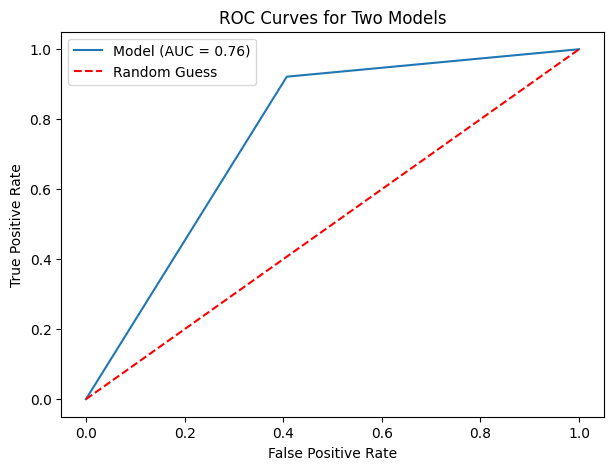

In [28]:


test_df = pd.DataFrame(
    {'True': y_test_np, 'Model': y_prob_in})

plt.figure(figsize=(7, 5))


fpr, tpr, _ = roc_curve(test_df['True'], test_df['Model'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Models')
plt.legend()
plt.show()

In [31]:


y_true = np.array([int(label) for label in y_test_np])  # true labels
y_pred = prediction_in                         # predicted class labels (e.g., from predict_batch)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred, average='macro')  # Use 'binary' if binary task
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Overall Accuracy (OA)
oa = accuracy_score(y_true, y_pred)

# Average Accuracy (AA) — mean of per-class accuracies
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
aa = per_class_acc.mean()

# Print all metrics
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"OA:        {oa:.4f}")
print(f"AA:        {aa:.4f}")

Precision: 0.5462
Recall:    0.7571
F1 Score:  0.4605
OA:        0.6080
AA:        0.7571


In [32]:

performance = {
    'AUC': float(roc_auc),
    'precision': float(precision),
    'recall': float(recall),
    'F1 Score': float(f1),
    'OA': float(oa),
    'AA': float(aa),
}
result_json = {
    'prediction' : scores,
    'performance' : performance,
}

In [36]:
import json
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
print(result_json)

with open(f"performance/LR {timestamp}_results.json", "w") as f:
    json.dump(result_json, f, indent=2)

print("JSON saved to results.json")

{'prediction': [{'dataset': 0, 'class0_size': 820876, 'class1_size': 29336, 'correct_0': 800075, 'correct_1': 19547, 'correct_total': 819622, 'total': 850212}, {'dataset': 1, 'class0_size': 1236269, 'class1_size': 12145, 'correct_0': 506492, 'correct_1': 12145, 'correct_total': 518637, 'total': 1248414}, {'dataset': 2, 'class0_size': 916980, 'class1_size': 39360, 'correct_0': 745401, 'correct_1': 38829, 'correct_total': 784230, 'total': 956340}, {'dataset': 3, 'class0_size': 959167, 'class1_size': 31849, 'correct_0': 776727, 'correct_1': 31584, 'correct_total': 808311, 'total': 991016}, {'dataset': 4, 'class0_size': 1363408, 'class1_size': 58562, 'correct_0': 1172712, 'correct_1': 56490, 'correct_total': 1229202, 'total': 1421970}, {'dataset': 5, 'class0_size': 1389552, 'class1_size': 53256, 'correct_0': 1142018, 'correct_1': 51891, 'correct_total': 1193909, 'total': 1442808}, {'dataset': 6, 'class0_size': 873365, 'class1_size': 93415, 'correct_0': 0, 'correct_1': 93415, 'correct_total

In [37]:
end_time = time.time()
print(f"Run time: {end_time - start_time:.4f} seconds")

Run time: 1243.0026 seconds
